# Section 1: Importing **Libraries**

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import shap

# Section 2: Data **Loading**

In [3]:
maternal = pd.read_csv('/content/maternal_health_risk.csv')
pree = pd.read_csv('/content/preeclampsia.csv')

# Section 3: Preprocessing
Cleaning and preparing data.





In [4]:
maternal['domain'] = 0
pree['domain'] = 1
maternal.rename(columns={'Age': 'age', 'SystolicBP': 'sysbp', 'DiastolicBP': 'diabp'}, inplace=True)
combined = pd.concat([maternal, pree], axis=0, ignore_index=True)

combined['target'] = np.where(combined['RiskLevel'] == 'high risk', 1, 0)
combined['target'] = combined['target'].fillna(combined['htn'].fillna(0))

features = ['age', 'sysbp', 'diabp', 'BS', 'BodyTemp', 'HeartRate', 'bmi', 'plgf:sflt', 'SEng']
X = combined[features].copy()
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=features)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Section 4: Graph **Construction**

In [5]:
G = nx.Graph()
for i in range(len(X_scaled)):
    G.add_node(i, features=X_scaled[i])

dist_matrix = euclidean_distances(X_scaled)
threshold = 0.3
for i in range(len(X_scaled)):
    for j in range(i + 1, len(X_scaled)):
        if dist_matrix[i][j] < threshold:
            G.add_edge(i, j, weight=1 - dist_matrix[i][j])

adj = nx.to_numpy_array(G)
adj_tensor = torch.tensor(adj, dtype=torch.float)
node_feats = torch.tensor(X_scaled, dtype=torch.float)
labels = torch.tensor(combined['target'].values, dtype=torch.float).unsqueeze(1)
domains = torch.tensor(combined['domain'].values, dtype=torch.float).unsqueeze(1)

#Section 5: 5-fold CV

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx_all, test_idx_all = next(cv.split(node_feats, labels.numpy()))

#Section 6: Updated GCN with Reconstruction Layer

In [7]:
class UpdatedGCN(nn.Module):
    def __init__(self, in_features, hidden=64, embed_size=32, dropout_rate=0.5):
        super().__init__()
        self.gcn1 = nn.Linear(in_features, hidden)
        self.gcn2 = nn.Linear(hidden, embed_size)
        self.recon_layer = nn.Linear(embed_size, in_features)
        self.domain_classifier = nn.Linear(embed_size, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, X, adj):
        adj_norm = adj + torch.eye(adj.size(0))
        degree = torch.sum(adj_norm, dim=1).clamp(min=1)
        adj_norm = adj_norm / degree.unsqueeze(1)
        emb = F.relu(self.gcn1(adj_norm @ X))
        emb = self.dropout(emb)
        emb = F.relu(self.gcn2(adj_norm @ emb))
        recon = self.recon_layer(emb)
        return emb, recon

    def domain_forward(self, emb):
        return torch.sigmoid(self.domain_classifier(emb))

#Section 7: Training GCN (simplified)

In [8]:
gnn_model = UpdatedGCN(in_features=node_feats.shape[1])
optimizer = Adam(gnn_model.parameters(), lr=0.01)
recon_criterion = nn.MSELoss()
domain_criterion = nn.BCELoss()
best_loss = float('inf')
patience = 10
counter = 0

maternal_idx = combined[combined['domain'] == 0].index
pree_idx = combined[combined['domain'] == 1].index
clients = [maternal_idx, pree_idx]

for epoch in range(100):
    total_loss = 0
    for client_idx in clients:
        optimizer.zero_grad()
        emb, recon = gnn_model(node_feats[client_idx], adj_tensor[client_idx][:, client_idx])
        recon_loss = recon_criterion(recon, node_feats[client_idx])
        domain_pred = gnn_model.domain_forward(emb)
        domain_loss = domain_criterion(domain_pred, domains[client_idx])
        loss = recon_loss + 0.5 * domain_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    with torch.no_grad():
        val_emb, val_recon = gnn_model(node_feats[test_idx_all], adj_tensor[test_idx_all][:, test_idx_all])
        val_loss = recon_criterion(val_recon, node_feats[test_idx_all])
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            break
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Val Loss {val_loss:.4f}")

Epoch 0: Val Loss 0.1647
Epoch 10: Val Loss 0.0458
Epoch 20: Val Loss 0.0245
Epoch 30: Val Loss 0.0213
Epoch 40: Val Loss 0.0185
Epoch 50: Val Loss 0.0166
Epoch 60: Val Loss 0.0170
Epoch 70: Val Loss 0.0139
Epoch 80: Val Loss 0.0134
Epoch 90: Val Loss 0.0115


#Section 8: Get embeddings

In [9]:
gnn_model.eval()
with torch.no_grad():
    embeddings, _ = gnn_model(node_feats, adj_tensor)
    embeddings = embeddings.numpy()

# Section 9: LightGBM Classifier

In [10]:
lgb_model = lgb.LGBMClassifier(class_weight='balanced', random_state=42)
lgb_model.fit(embeddings[train_idx_all], labels[train_idx_all].numpy().ravel())

[LightGBM] [Info] Number of positive: 217, number of negative: 914
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5676
[LightGBM] [Info] Number of data points in the train set: 1131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMClassifier(class_weight='balanced', random_state=42)

#Section 10: Evaluation

In [11]:
test_preds = lgb_model.predict(embeddings[test_idx_all])
acc = accuracy_score(labels[test_idx_all].numpy(), test_preds)
auc = roc_auc_score(labels[test_idx_all].numpy(), lgb_model.predict_proba(embeddings[test_idx_all])[:, 1])
print(f"GCN + LightGBM Accuracy: {acc:.4f}, AUC: {auc:.4f}")
print(classification_report(labels[test_idx_all].numpy(), test_preds))

GCN + LightGBM Accuracy: 0.9470, AUC: 0.9843
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97       228
         1.0       0.82      0.93      0.87        55

    accuracy                           0.95       283
   macro avg       0.90      0.94      0.92       283
weighted avg       0.95      0.95      0.95       283



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# Section 11:  Visualizations

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


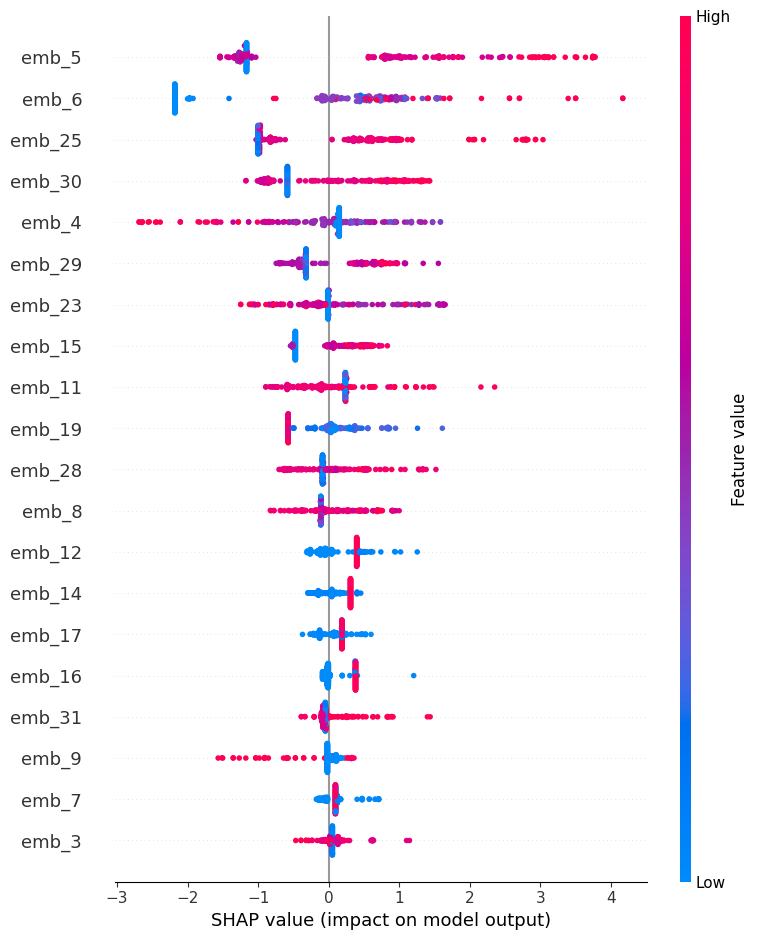

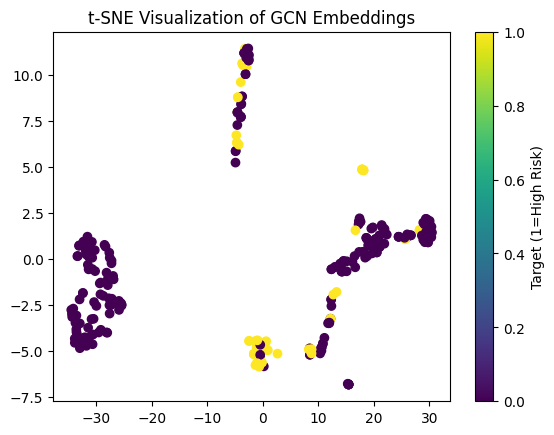

In [12]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(embeddings[test_idx_all])
shap.summary_plot(shap_values, embeddings[test_idx_all], feature_names=[f'emb_{i}' for i in range(embeddings.shape[1])])

tsne = TSNE(n_components=2, random_state=42)
embed_2d = tsne.fit_transform(embeddings[test_idx_all])
plt.scatter(embed_2d[:, 0], embed_2d[:, 1], c=labels[test_idx_all].numpy(), cmap='viridis')
plt.colorbar(label='Target (1=High Risk)')
plt.title('t-SNE Visualization of GCN Embeddings')
plt.show()